# Module 4.1: Ensemble Regression Analysis

This notebook explores ensemble regression methods (Random Forest, Histogram Gradient Boosting, and optional XGBoost / LightGBM) in a semiconductor manufacturing context. We use a synthetic dataset representing engineered process signals and derived interaction features to predict a numerical target (e.g., critical dimension deviation or yield proxy).


## Learning Objectives

By the end of this notebook you will be able to:

- Generate and inspect a synthetic regression dataset with engineered features.
- Train and evaluate multiple ensemble regressors with a unified pipeline API.
- Compare model performance using RMSE, MAE, and R².
- Persist a trained model and reload it for inference.
- Invoke the CLI pipeline (train / evaluate / predict) programmatically.
- Interpret ensemble feature relationships and discuss manufacturing relevance.


## Semiconductor Context

In fabrication, predictive models help anticipate downstream parametric drift, identify process excursions, and optimize tool maintenance schedules. Ensemble regressors are strong baselines because:

- They reduce variance (bagging) or bias (boosting) relative to single trees.
- They naturally capture nonlinear interactions without explicit feature crafting.
- They provide quick, robust performance for tabular, mixed-scale process features.

We treat the synthetic dataset as a stand‑in for aggregated lot-level statistics (e.g., mean temperature offsets, pressure stability indices, spectral sensor transforms). The engineered features (`x1_x3`, `sin_x2`) mimic common manufacturing domain transformations (interaction & waveform decomposition).


In [5]:
# Imports & Setup
from __future__ import annotations
import os, sys, json, subprocess, textwrap, math, runpy
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

CWD = Path(os.getcwd()).resolve()
# If current dir is the module-4 folder, use it directly; else try to locate it.
if CWD.name == 'module-4' and (CWD / '4.1-ensemble-pipeline.py').exists():
    BASE_DIR = CWD
elif (CWD / 'modules' / 'intermediate' / 'module-4' / '4.1-ensemble-pipeline.py').exists():
    BASE_DIR = CWD / 'modules' / 'intermediate' / 'module-4'
else:
    # Fallback attempt: walk up a few levels
    found = None
    for up in [CWD] + list(CWD.parents)[:4]:
        candidate = up / 'modules' / 'intermediate' / 'module-4' / '4.1-ensemble-pipeline.py'
        if candidate.exists():
            found = candidate.parent
            break
    if not found:
        raise FileNotFoundError('Could not locate 4.1-ensemble-pipeline.py relative to working directory')
    BASE_DIR = found

PIPELINE_PATH = BASE_DIR / '4.1-ensemble-pipeline.py'
print('Resolved pipeline path:', PIPELINE_PATH)

ns = runpy.run_path(str(PIPELINE_PATH))
EnsemblePipeline = ns['EnsemblePipeline']
generate_regression_synthetic = ns['generate_regression_synthetic']
TARGET_COLUMN = ns['TARGET_COLUMN']
RANDOM_SEED = ns['RANDOM_SEED']

sns.set_theme(context='notebook', style='whitegrid')
np.random.seed(RANDOM_SEED)
print('Loaded EnsemblePipeline; optional libs -> HAS_XGB:', ns.get('HAS_XGB'), 'HAS_LGB:', ns.get('HAS_LGB'))

Resolved pipeline path: C:\Users\Micha\OneDrive\Documents\Projects\python-for-semiconductors-\modules\intermediate\module-4\4.1-ensemble-pipeline.py
Loaded EnsemblePipeline; optional libs -> HAS_XGB: False HAS_LGB: False


In [6]:
# Generate Synthetic Dataset
raw_df = generate_regression_synthetic(n=600, seed=RANDOM_SEED)
print("Shape:", raw_df.shape)
raw_df.head()

Shape: (600, 6)


,x1,x2,x3,x1_x3,sin_x2,target
0,0.304717,4.773116,-1.172059,-0.357147,-0.998157,-1.039147
1,-1.039984,3.133692,-0.309064,0.321422,0.007901,-0.754728
2,0.750451,5.911671,-1.295447,-0.972170,-0.363027,-0.797166
3,0.940565,3.058619,-1.461232,-1.374383,0.082879,0.708058
4,-1.951035,3.045077,1.441128,-2.811691,0.096366,-3.780447


In [7]:
# Basic Summary Statistics
summary = raw_df.describe().T
summary[['mean','std','min','max']]

,mean,std,min,max
x1,-0.026165,0.973805,-2.964529,2.913862
x2,3.972535,1.497062,-1.472619,8.768281
x3,0.040091,1.153882,-1.982777,1.995319
x1_x3,-0.031122,1.130688,-4.886719,3.789133
sin_x2,-0.268047,0.664203,-0.999996,1.000000
target,-0.230633,2.219322,-6.798473,7.970753


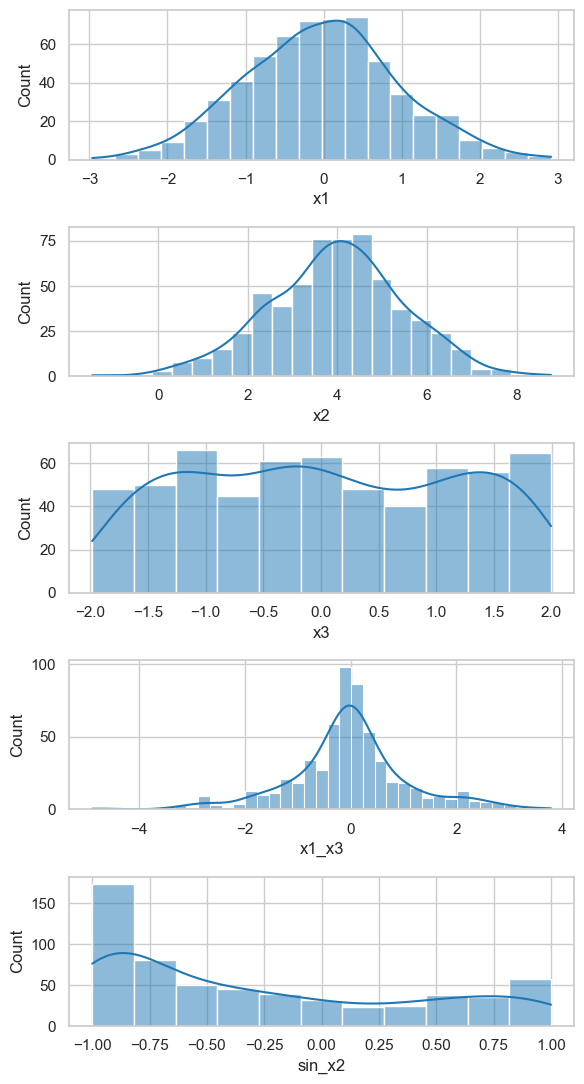

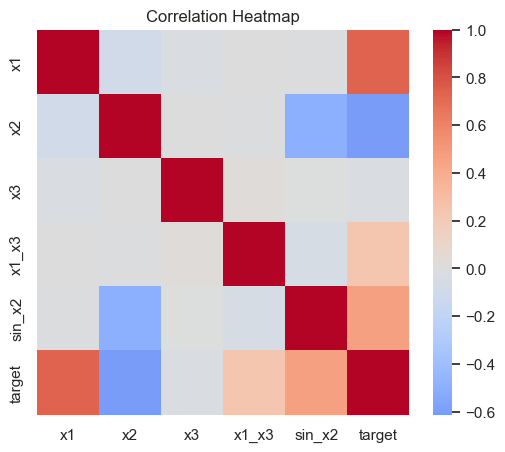

In [8]:
# EDA: Feature Distributions & Correlation
feature_cols = [c for c in raw_df.columns if c != TARGET_COLUMN]
fig, axes = plt.subplots(len(feature_cols), 1, figsize=(6, 2.2*len(feature_cols)))
for ax, col in zip(axes, feature_cols):
    sns.histplot(raw_df[col], kde=True, ax=ax, color='#1f77b4')
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

corr = raw_df[feature_cols + [TARGET_COLUMN]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [9]:
# Train Baseline Random Forest
from math import floor

train_frac = 0.8
cut = floor(train_frac * len(raw_df))
train_df = raw_df.iloc[:cut].copy()
val_df = raw_df.iloc[cut:].copy()

X_train = train_df.drop(columns=[TARGET_COLUMN])
X_val = val_df.drop(columns=[TARGET_COLUMN])
y_train = train_df[TARGET_COLUMN].to_numpy()
y_val = val_df[TARGET_COLUMN].to_numpy()

rf_pipe = EnsemblePipeline(model='rf', n_estimators=300, max_depth=8)
rf_pipe.fit(X_train, y_train)
val_metrics = rf_pipe.evaluate(X_val, y_val)
val_metrics

{'R2': 0.9120570387101363,
 'RMSE': 0.6661337108656659,
 'MAE': 0.5270484397708253}

In [10]:
# Model Comparison Across Ensembles
candidates = ['rf', 'hist_gb']
if HAS_XGB:
    candidates.append('xgb')
if HAS_LGB:
    candidates.append('lgbm')

results = []
for m in candidates:
    pipe = EnsemblePipeline(model=m)
    pipe.fit(X_train, y_train)
    metrics = pipe.evaluate(X_val, y_val)
    row = {'model': m, **metrics}
    results.append(row)

comp_df = pd.DataFrame(results).sort_values('RMSE')
comp_df

NameError: name 'HAS_XGB' is not defined

In [ ]:
# Persistence Demo (Save / Load / Predict)
from pathlib import Path
model_path = Path('temp_models/ensemble_rf.joblib')
model_path.parent.mkdir(exist_ok=True, parents=True)
rf_pipe.save(model_path)
reloaded = EnsemblePipeline.load(model_path)
sample_pred = reloaded.predict(X_val.iloc[:1])[0]
print("Reloaded model type:", reloaded.metadata.model_type if reloaded.metadata else None)
print("Sample prediction:", float(sample_pred))

In [ ]:
# CLI Demonstration (Train -> Evaluate -> Predict)
import json, subprocess, tempfile

# Write a temp CSV for CLI demo
csv_path = Path('temp_cli_train.csv')
raw_df.to_csv(csv_path, index=False)
model_out = Path('temp_models/cli_rf.joblib')

train_cmd = [sys.executable, '4.1-ensemble-pipeline.py', 'train', '--model', 'rf', '--train', str(csv_path), '--model-out', str(model_out)]
print('TRAIN CMD:', ' '.join(train_cmd))
train_res = subprocess.run(train_cmd, capture_output=True, text=True, check=True)
print('Train JSON:', train_res.stdout.strip())

# Evaluate
eval_cmd = [sys.executable, '4.1-ensemble-pipeline.py', 'evaluate', '--model-path', str(model_out), '--data', str(csv_path)]
print('\nEVAL CMD:', ' '.join(eval_cmd))
eval_res = subprocess.run(eval_cmd, capture_output=True, text=True, check=True)
print('Eval JSON:', eval_res.stdout.strip())

# Predict (take first record sans target)
record = raw_df.drop(columns=[TARGET_COLUMN]).iloc[0].to_dict()
pred_cmd = [sys.executable, '4.1-ensemble-pipeline.py', 'predict', '--model-path', str(model_out), '--input-json', json.dumps(record)]
print('\nPRED CMD:', ' '.join(pred_cmd))
pred_res = subprocess.run(pred_cmd, capture_output=True, text=True, check=True)
print('Pred JSON:', pred_res.stdout.strip())

### 12. Manufacturing-Oriented Metrics & Interpretation

While our implemented regression metrics (MAE, RMSE, R²) describe statistical performance, semiconductor engineering decisions often require translating model error into process impact:

- **Prediction Within Spec (PWS)**: Percentage of predictions whose absolute error is within an engineering tolerance band. For parametric tests (e.g., line width, film thickness) this tolerance could come from the process control plan. Example:
  ```python
  tolerance = 0.5  # nanometers, milliohms, etc.
  pws = (np.abs(y_pred - y_true) <= tolerance).mean()
  ```
- **Estimated Loss / Cost of Error**: Map absolute error to monetary impact (scrap, rework, cycle time). A simple linear model might assume cost_per_unit * |error|; more advanced curves could be stepwise (no cost until spec boundary, then escalating).
- **Stability / Drift Tracking**: Compare residual distributions by lot, tool, or time window to flag emerging drift.
- **Actionability Thresholds**: Define when a prediction should trigger: (a) a re-measure, (b) an engineering review, (c) a tool maintenance event.

These domain metrics are not yet coded into the pipeline but can be layered on top of predictions. Example enrichment function:
```python
from dataclasses import dataclass

@dataclass
class ManufacturingEval:
    mae: float
    rmse: float
    r2: float
    pws: float
    avg_cost: float

def manufacturing_evaluate(y_true, y_pred, tolerance=0.5, cost_per_unit=2.0):
    abs_err = np.abs(y_pred - y_true)
    pws = (abs_err <= tolerance).mean()
    avg_cost = (abs_err * cost_per_unit).mean()
    return ManufacturingEval(
        mae=float(abs_err.mean()),
        rmse=float(np.sqrt(np.mean(abs_err**2))),
        r2=float(1 - ((abs_err**2).sum() / ((y_true - y_true.mean())**2).sum())),
        pws=float(pws),
        avg_cost=float(avg_cost),
    )
```

In a production extension of this module we would:
1. Parameterize tolerance and cost models via a JSON/YAML config.
2. Add these outputs to the pipeline `evaluate()` JSON.
3. Log evaluation outputs over time for SPC-style monitoring.
4. Couple to alerting (e.g., if PWS drops below 92%).

For now, treat this section as a conceptual bridge between generic ML metrics and fab decision intelligence.


### 13. Conclusions & Next Steps

**What we accomplished:**
- Built and evaluated multiple ensemble regressors (RF, HistGB, optionally XGBoost / LightGBM).
- Compared metrics (MAE, RMSE, R²) to choose candidates.
- Demonstrated persistence (save/load) and CLI parity with programmatic API.
- Outlined how to extend evaluation with manufacturing-aware KPIs (PWS, cost impact).

**Key Takeaways:**
- HistGradientBoosting is a strong default when XGBoost/LightGBM aren't installed, offering speed + accuracy.
- Metric differences should be interpreted relative to process tolerance, not just raw absolute values.
- A standardized CLI emitting JSON accelerates downstream automation (batch scoring, pipeline orchestration).

**Recommended Extensions:**
1. Add permutation/SHAP-based feature importance for interpretability.
2. Introduce PWS and cost metrics directly into `evaluate()` pipeline method.
3. Track evaluation outputs over time (lot / tool dimension) for drift signals.
4. Integrate hyperparameter search (Optuna / randomized search) with reproducible seed control.
5. Add residual diagnostics (QQ plot, residual vs. prediction) to probe model calibration.

**Bridge to 4.2 (Unsupervised Analysis):**
The next module (4.2) shifts from supervised yield/parameter prediction to pattern discovery and anomaly detection (clustering + isolation). You can:
- Reuse the synthetic data generation pattern for unsupervised embeddings.
- Combine ensemble residuals with clustering scores for hybrid monitoring.

Proceed to open `4.2-unsupervised-analysis.ipynb` (to be created) and replicate the structure: data synthesis → exploratory structure → clustering / anomaly model comparison → manufacturing interpretation.

> Save this notebook now so executed cell outputs (metrics tables, JSON CLI results) persist for later reference.
